In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import ta
from ta.utils import dropna
from pandas_datareader import data as web

sns.set(style='darkgrid', context='talk', palette='Dark2')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

my_year_month_fmt = mdates.DateFormatter('%m/%y')

%store -r close
data = close

In [2]:
# Calculating the short-window simple moving average
short_rolling = data.rolling(window=20).mean()
short_rolling.head(21)

Symbols,AAPL,MSFT,^GSPC,TSLA
2015-01-01,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN
2015-01-09,NaN,NaN,NaN,NaN
2015-01-12,NaN,NaN,NaN,NaN
2015-01-13,NaN,NaN,NaN,NaN
2015-01-14,NaN,NaN,NaN,NaN


In [3]:
# Calculating the long-window simple moving average
long_rolling = data.rolling(window=100).mean()
long_rolling.tail()

Symbols,AAPL,MSFT,^GSPC,TSLA
2020-06-08,293.333200,170.9687,2945.047986,701.793600
2020-06-09,293.607400,171.2017,2943.911885,705.728300
2020-06-10,293.958800,171.5131,2942.595784,710.283201
2020-06-11,294.125500,171.7086,2939.361384,714.289601
2020-06-12,294.330399,171.9356,2936.819785,717.994201


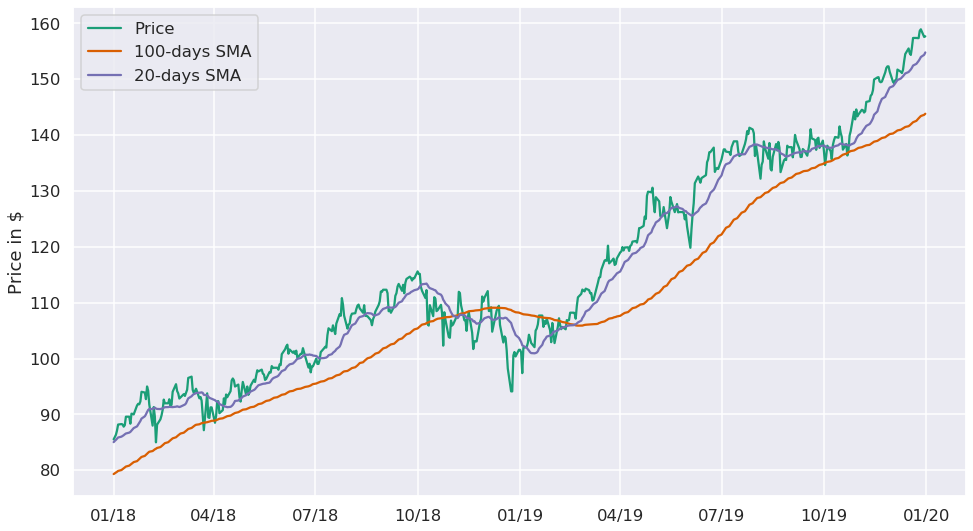

In [4]:
#Let us plot the last 2 years for these three timeseries for Microsoft stock, to get a feeling about how these behave.

start_date = '2018-01-01'
end_date = '2019-12-31'

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'MSFT'], label='Price')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'MSFT'], label = '100-days SMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'MSFT'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

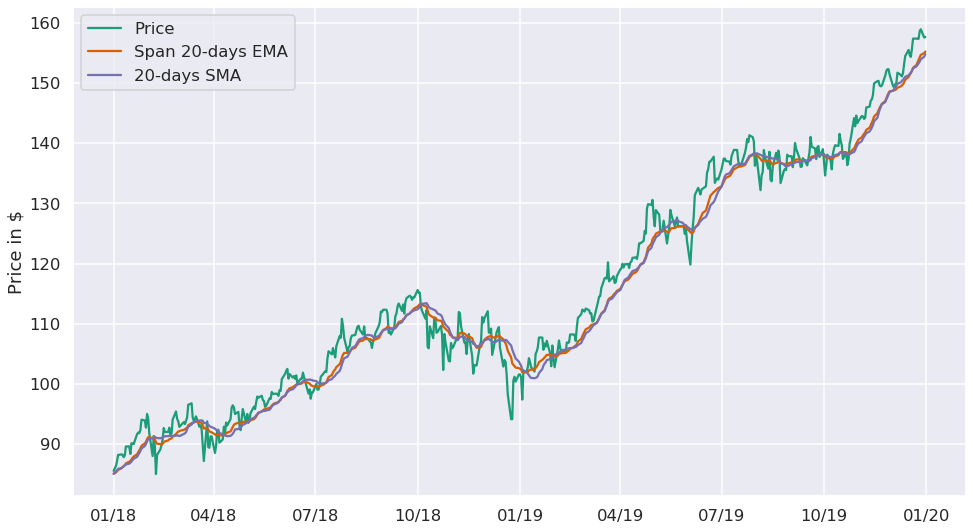

In [5]:
# Using Pandas to calculate a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
ema_short = data.ewm(span=20, adjust=False).mean()

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'MSFT'], label='Price')
ax.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'MSFT'], label = 'Span 20-days EMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'MSFT'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

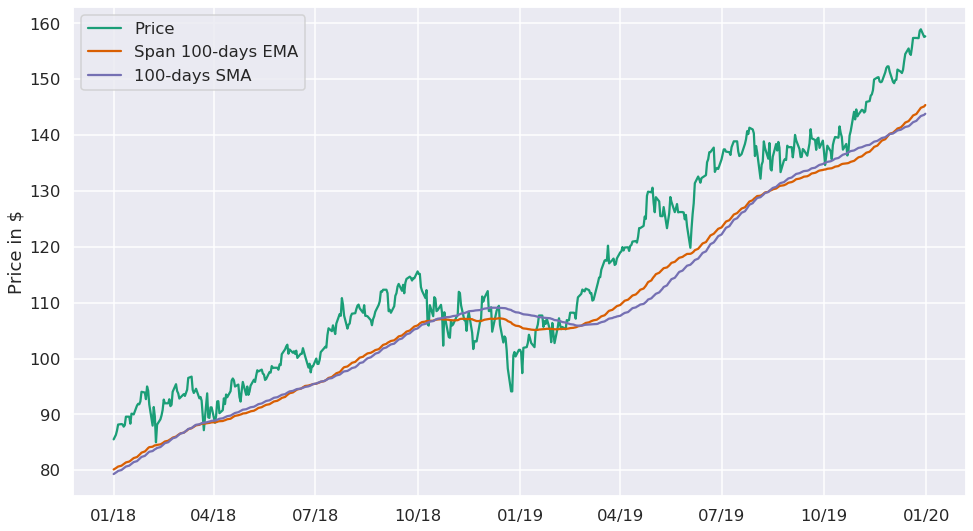

In [6]:
# Using Pandas to calculate a 100-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
ema_long = data.ewm(span=100, adjust=False).mean()

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'MSFT'], label='Price')
ax.plot(ema_long.loc[start_date:end_date, :].index, ema_long.loc[start_date:end_date, 'MSFT'], label = 'Span 100-days EMA')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'MSFT'], label = '100-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [7]:
# Moving average trading strategy: 
# First one: taking advantage of the lag between the price and ema series: 
# - When the price timeseries p(t) crosses the EMA timeseries e(t) from below, we will close any existing short position and go long (buy) one unit of the asset.
# - When the price timeseries p(t) crosses the EMA timeseries e(t) from above, we will close any existing long position and go short (sell) one unit of the asset.
#
# Taking the difference between the prices and the EMA timeseries

trading_positions_raw = data - ema_short
trading_positions_raw.tail()

Symbols,AAPL,MSFT,^GSPC,TSLA
2020-06-08,15.983609,5.217220,201.984280,108.156739
2020-06-09,23.988502,6.023201,159.938669,89.487050
2020-06-10,29.711031,11.819081,129.289237,157.308343
2020-06-11,11.554740,1.130128,-53.155267,95.088957
2020-06-12,13.078093,2.352498,-12.617181,52.050011


In [8]:
# Taking the sign of the difference to determine whether the price or the EMA is greater and then multiplying by 1/4
trading_positions = trading_positions_raw.apply(np.sign) * 1/4
trading_positions.tail()

Symbols,AAPL,MSFT,^GSPC,TSLA
2020-06-08,0.25,0.25,0.25,0.25
2020-06-09,0.25,0.25,0.25,0.25
2020-06-10,0.25,0.25,0.25,0.25
2020-06-11,0.25,0.25,-0.25,0.25
2020-06-12,0.25,0.25,-0.25,0.25


In [9]:
# One final caveat
# We don't really now the behaviour on the first day, so we shift of one day and assume we traded at the close of the first day
# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)

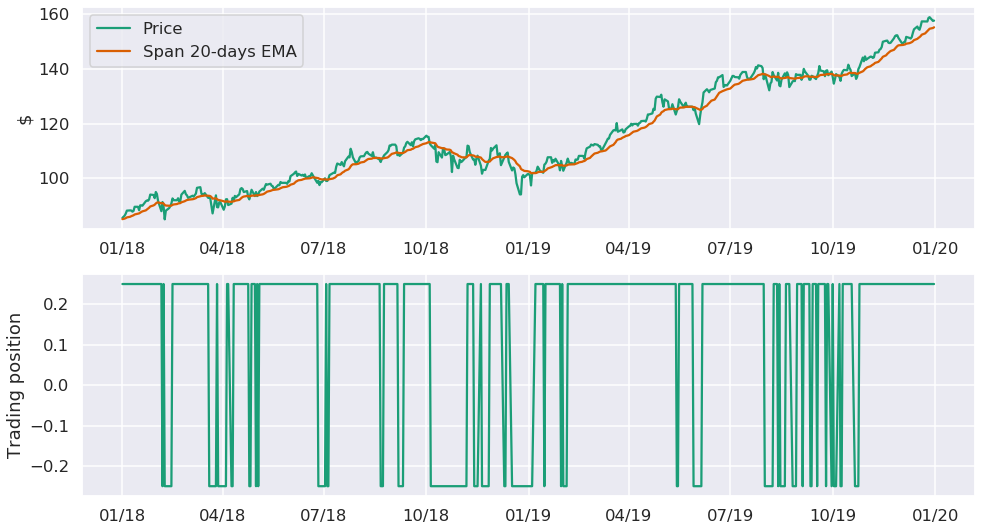

In [10]:
#Let us examine what the timeseries and the respective trading position look like for one of our assets, Microsoft.

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

ax1.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'MSFT'], label='Price')
ax1.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'MSFT'], label = 'Span 20-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date, 'MSFT'], 
        label='Trading position')

ax2.set_ylabel('Trading position')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

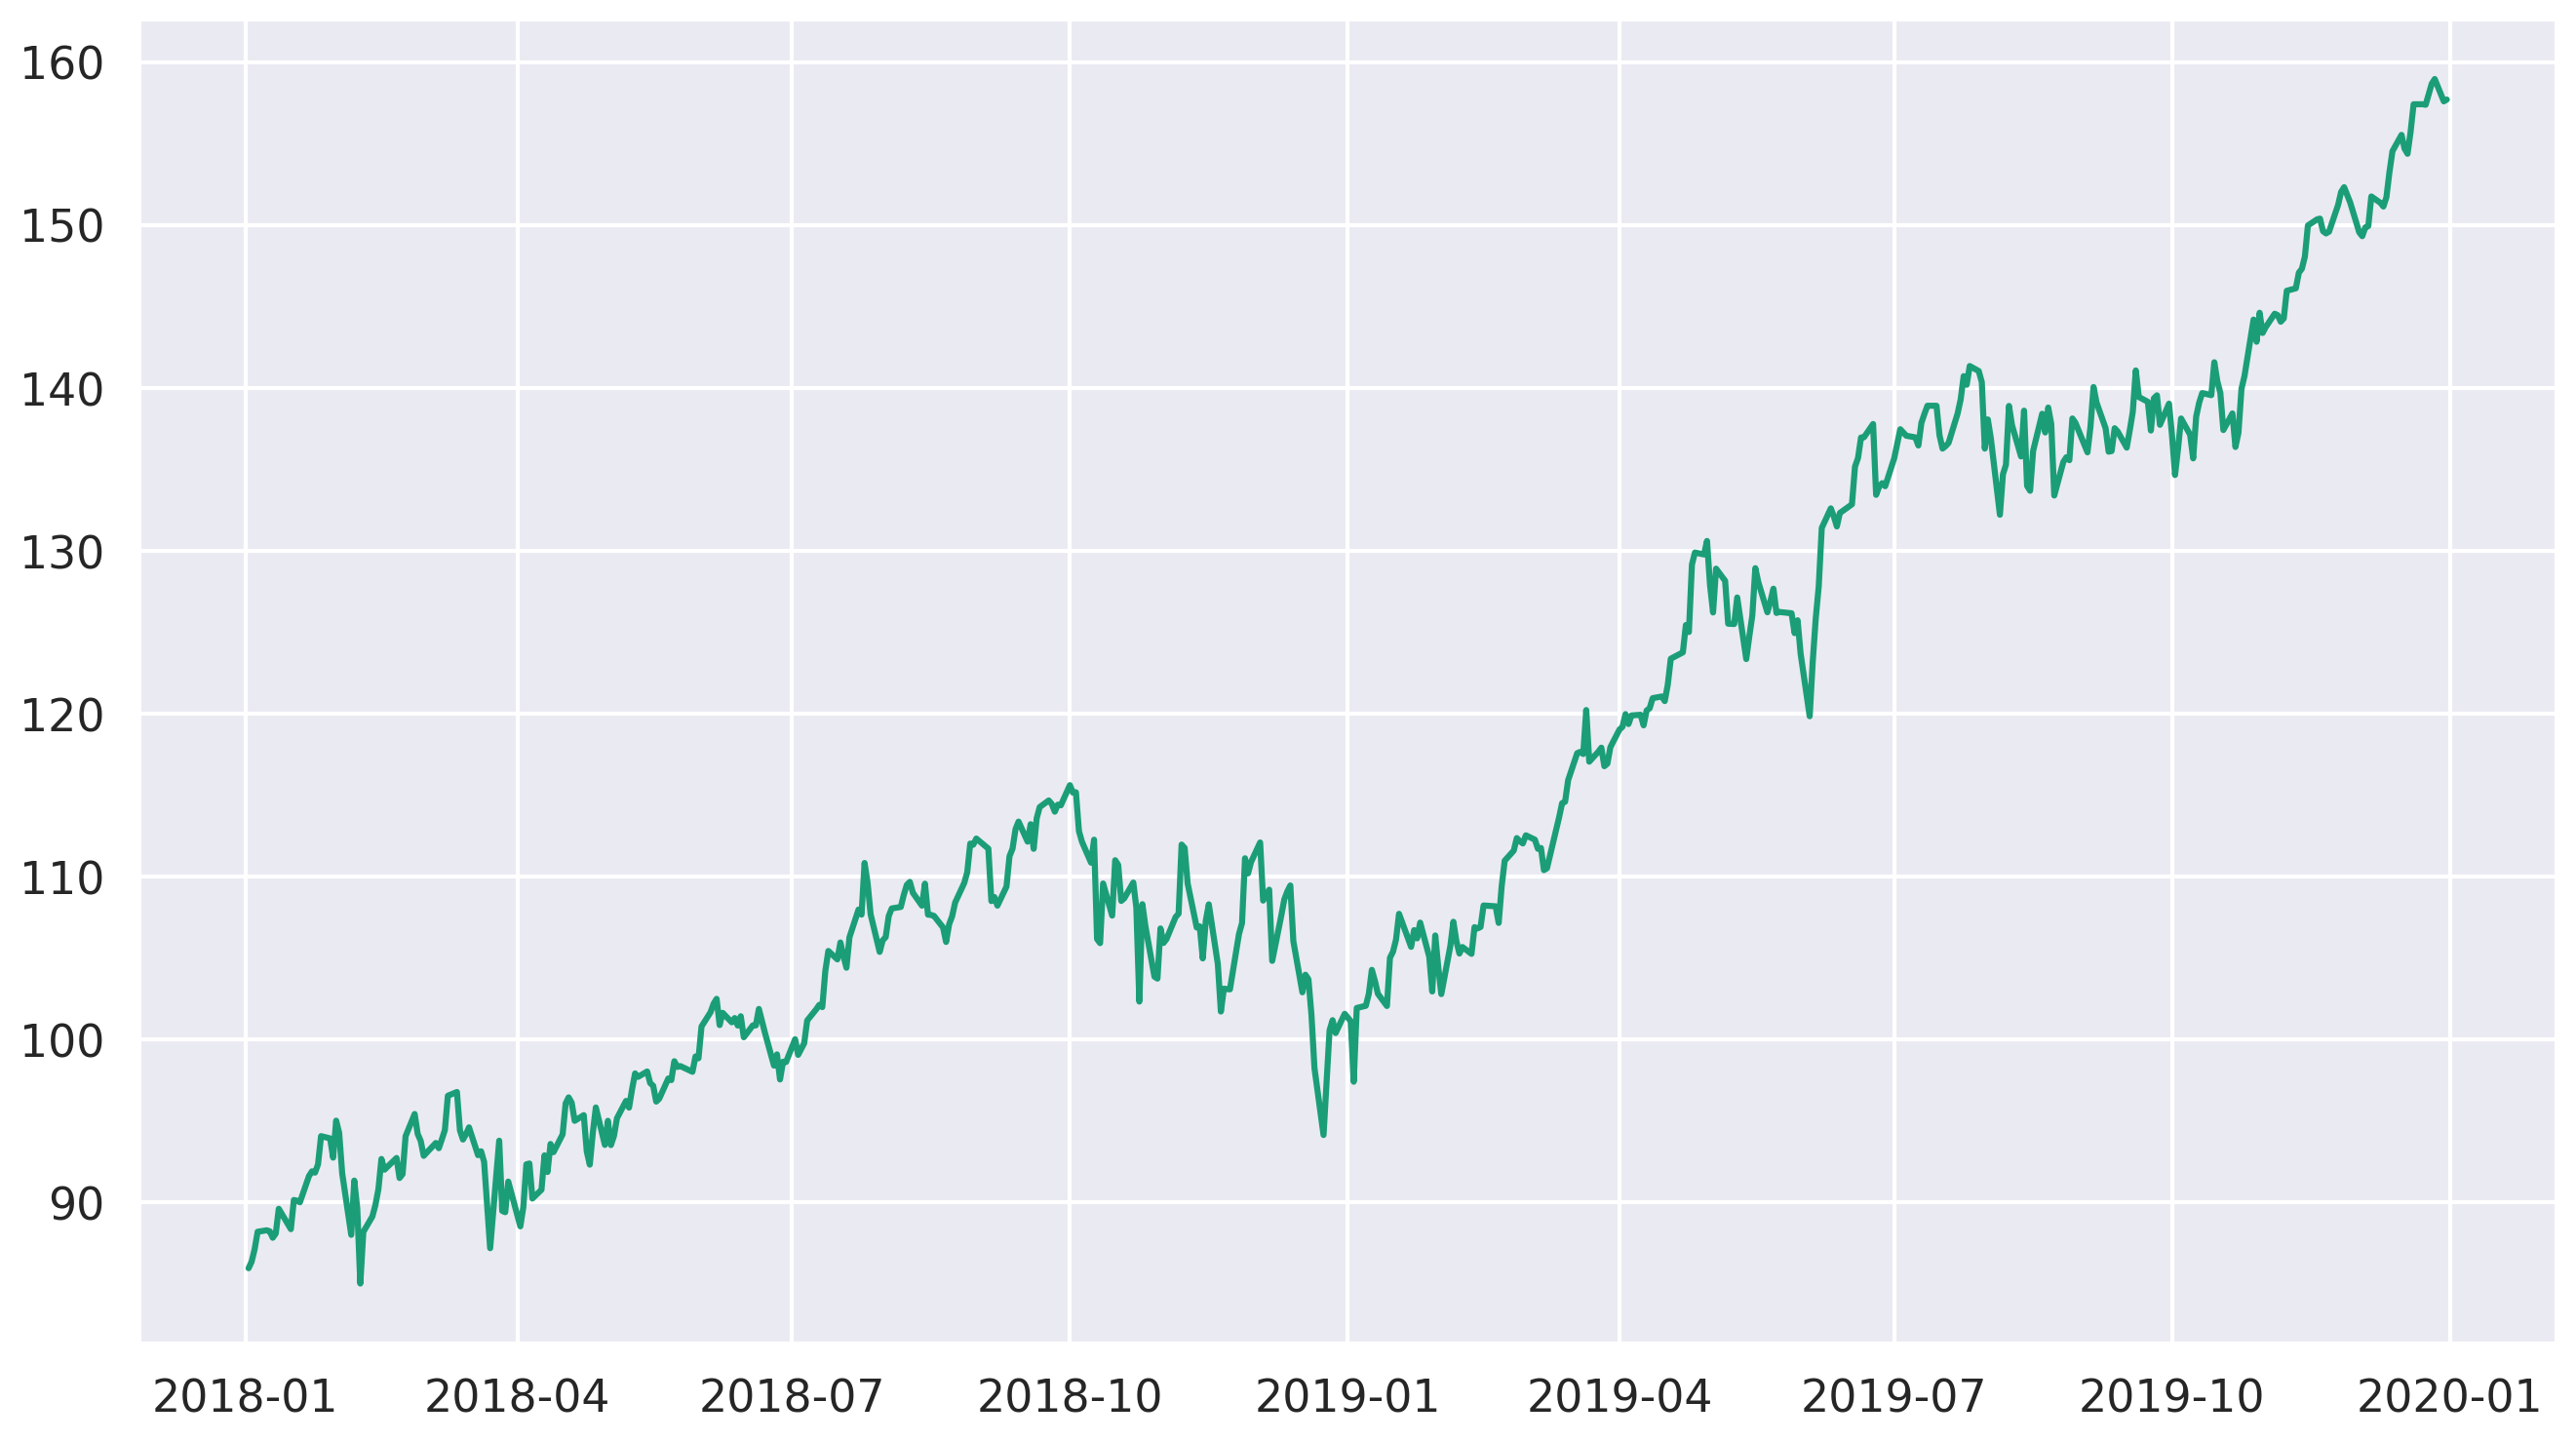

In [22]:
# MACD Simulation

df = web.DataReader('MSFT', data_source='yahoo', start=start_date, end=end_date)
df = dropna(df)
plt.plot(df['Close'])

In [23]:
macd = ta.trend.MACD(close=df['Close'], n_slow=31, n_fast= 15,n_sign=9)
df['MACD'] = macd.macd_diff()

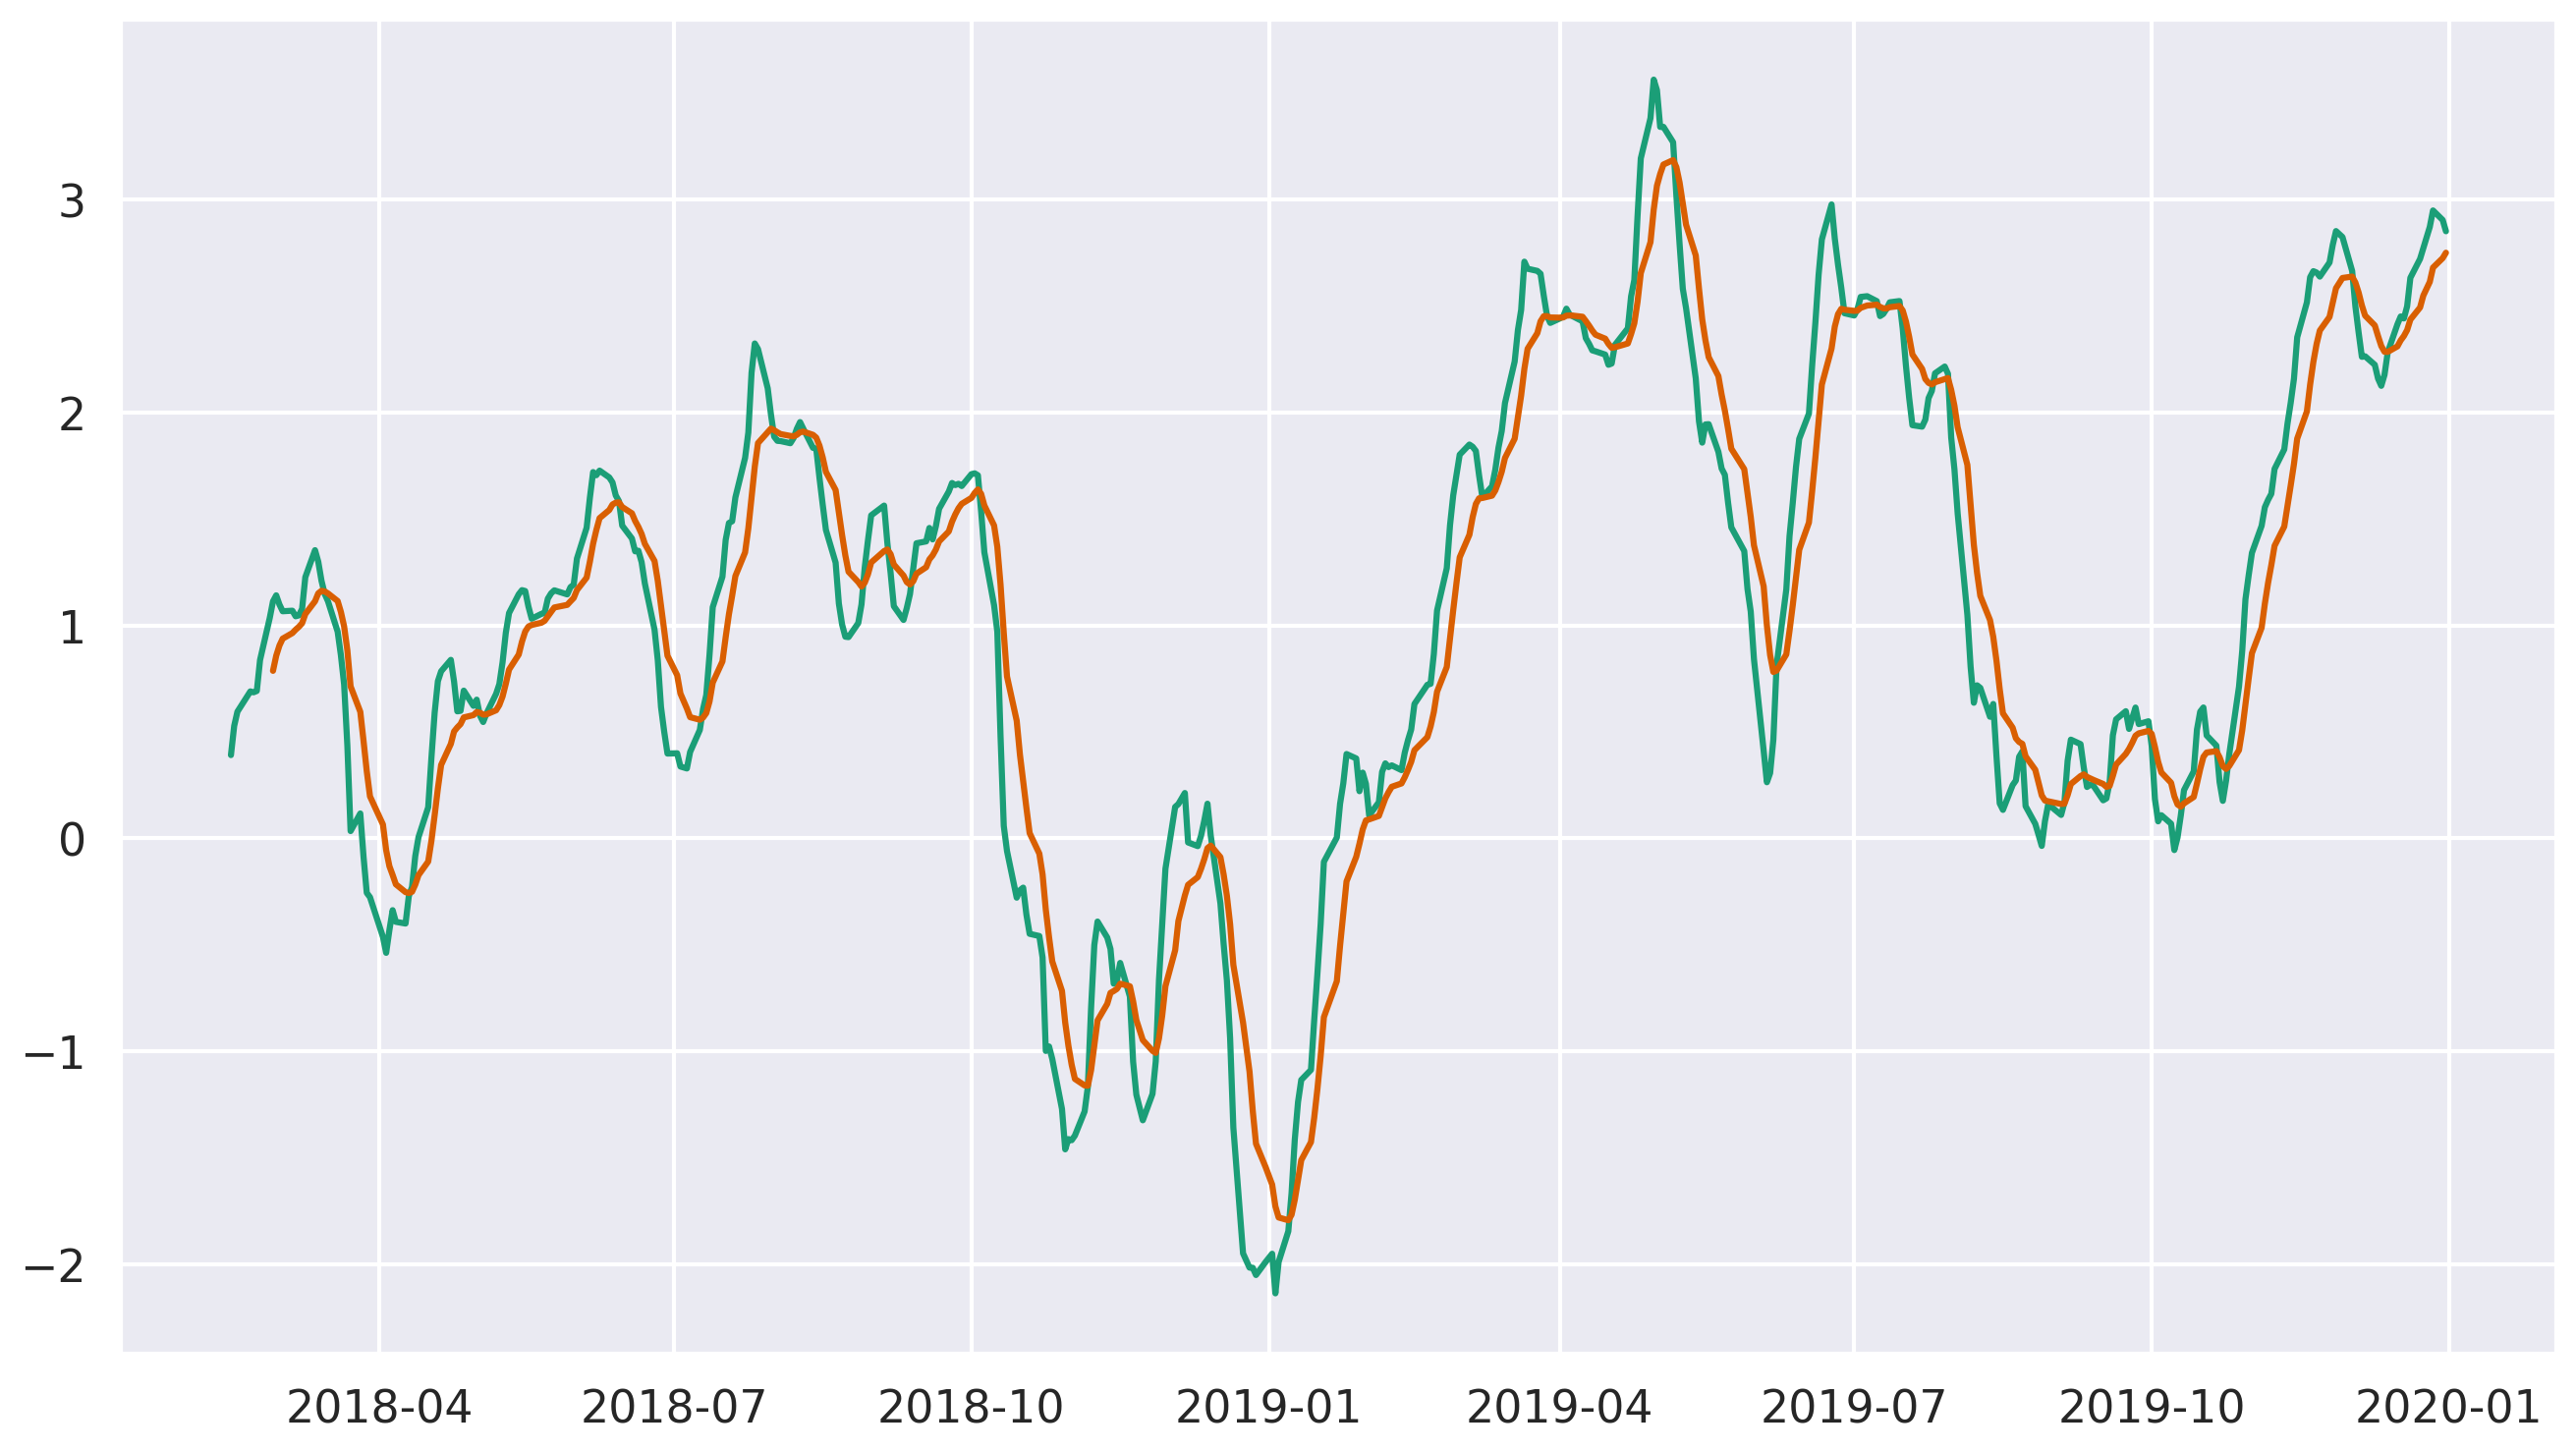

In [24]:
plt.plot(macd.macd())
plt.plot(macd.macd_signal())

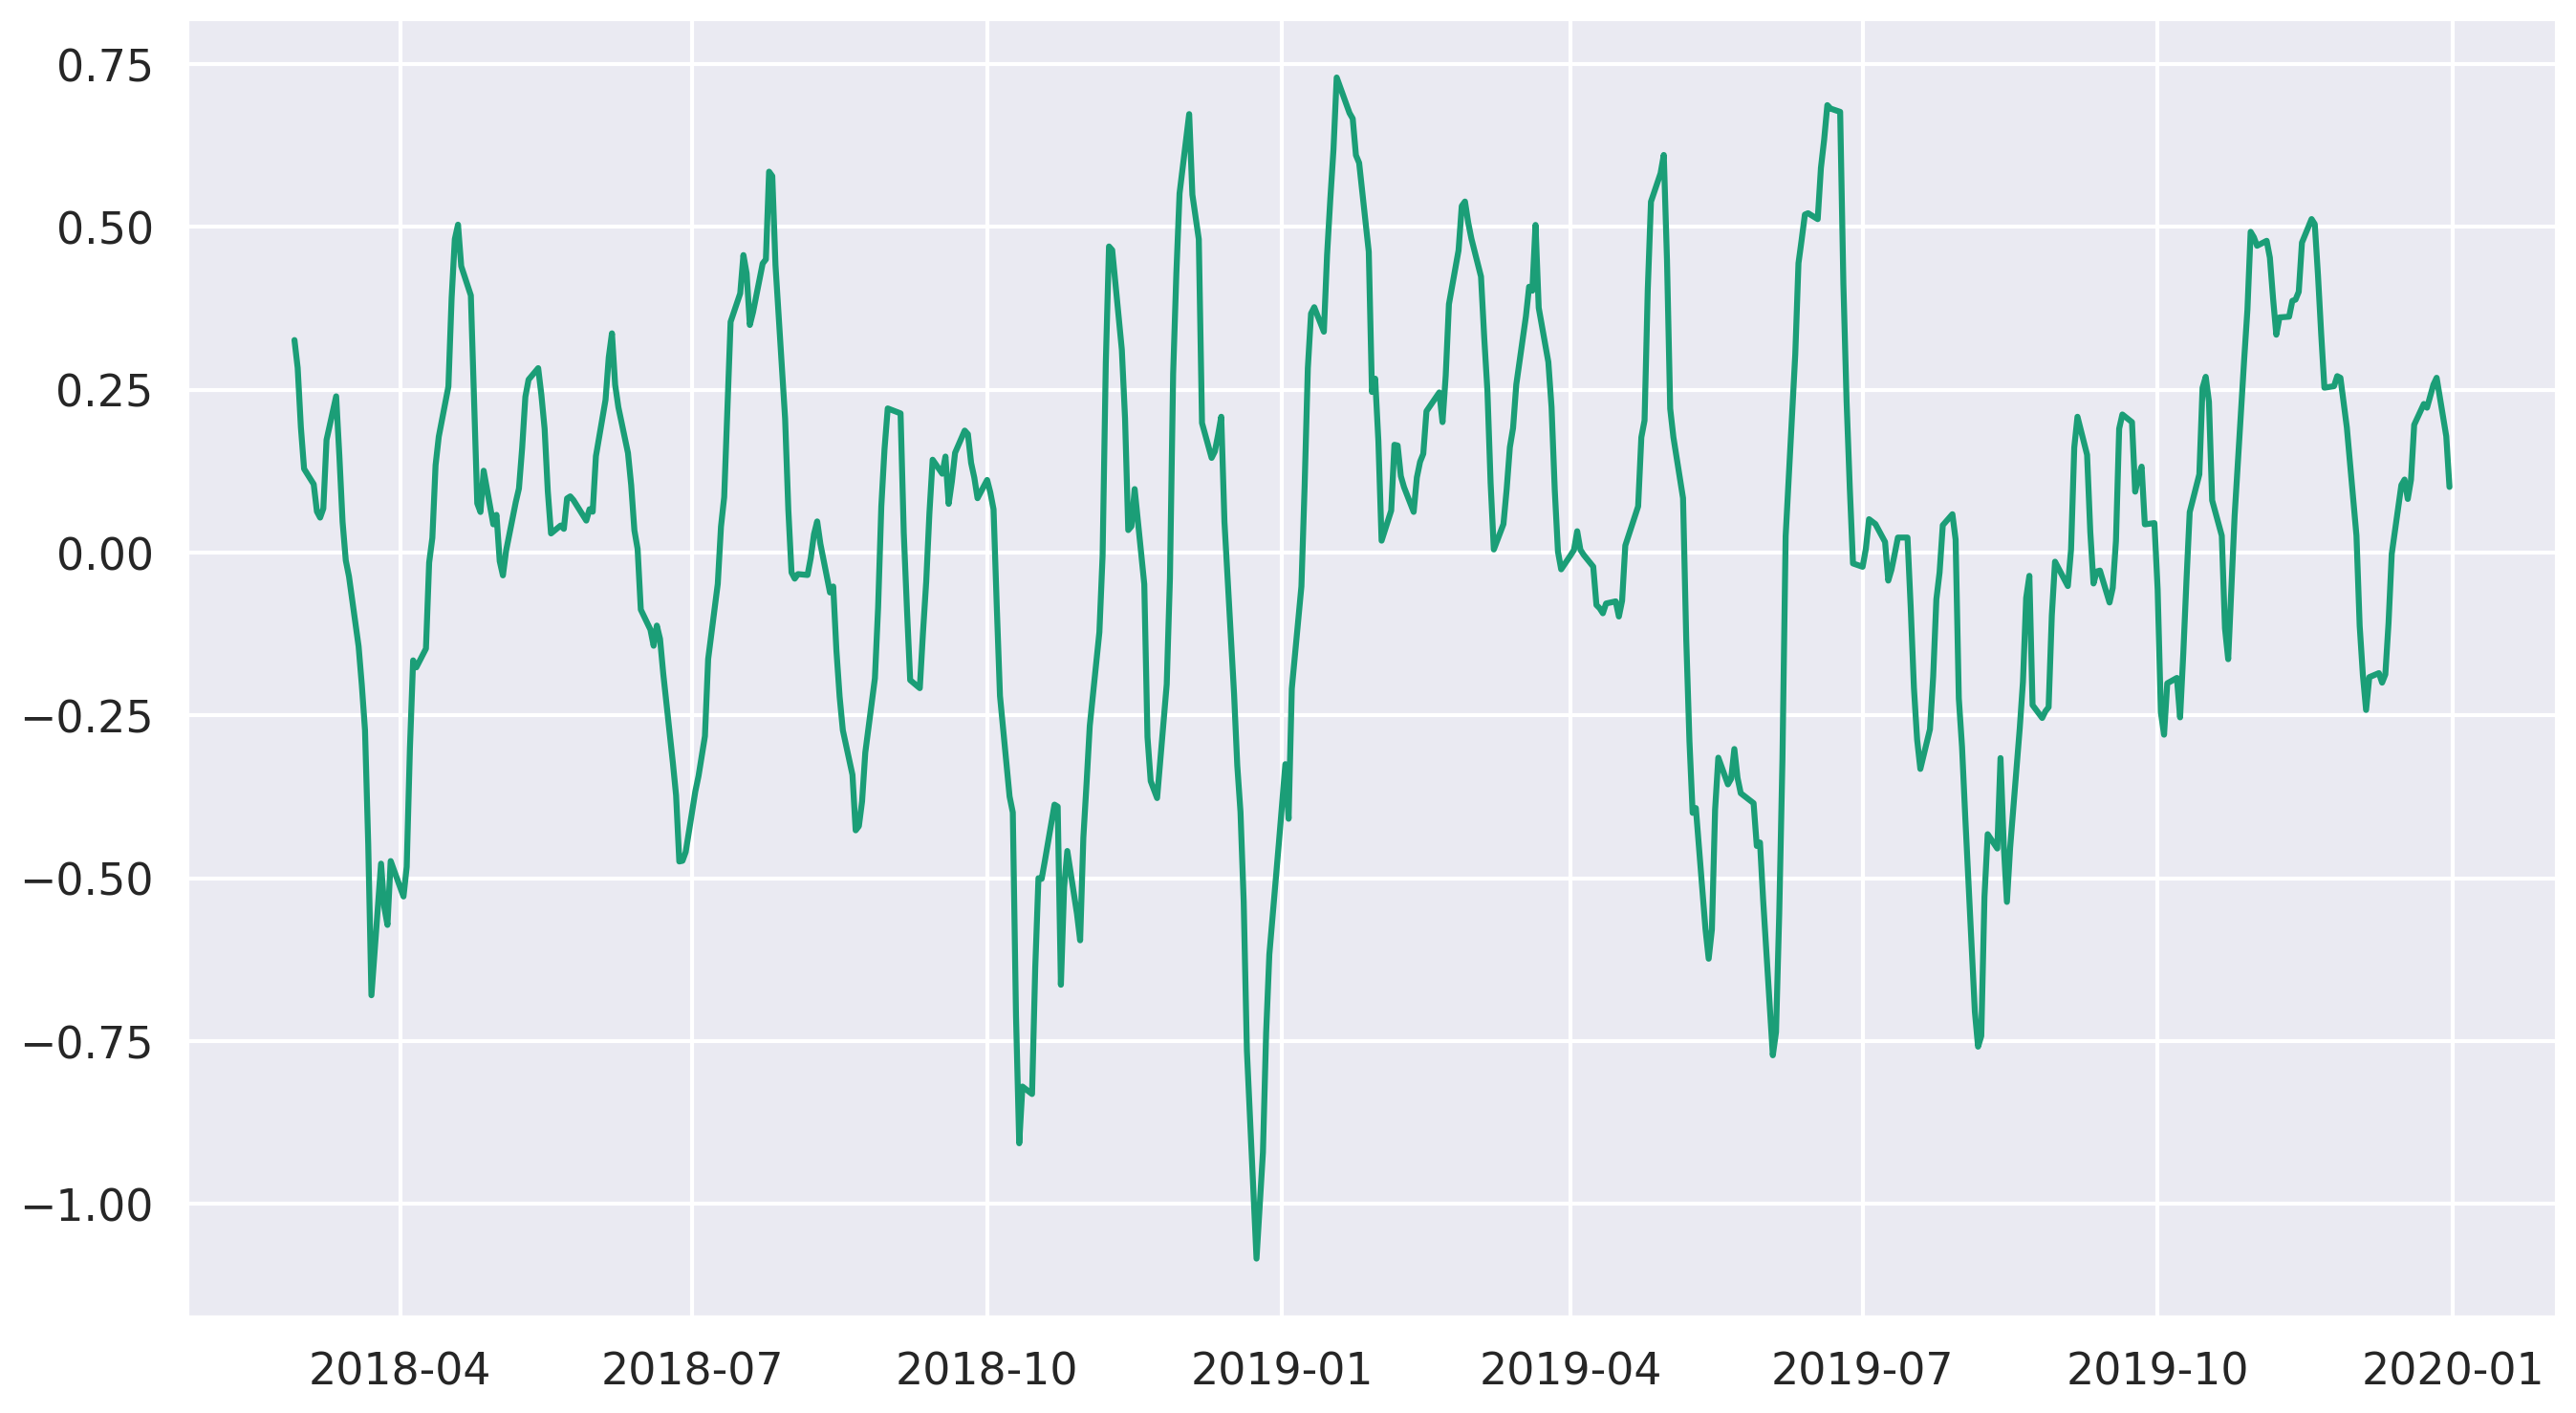

In [25]:
plt.plot(macd.macd_diff())

In [15]:
# Now that the position our strategy dictates each day has been calculated, the performance of this strategy can be easily estimated.
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations

asset_log_returns = np.log(data).diff()
asset_log_returns.head()

Symbols,AAPL,MSFT,^GSPC,TSLA
2015-01-01,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.028576,-0.009238,-0.018447,-0.042950
2015-01-06,0.000094,-0.014786,-0.008933,0.005648
2015-01-07,0.013925,0.012625,0.011563,-0.001563


In [16]:
# To get all the strategy log-returns for all days, one needs simply to multiply the strategy positions with the asset log-returns.
strategy_asset_log_returns = trading_positions_final * asset_log_returns
strategy_asset_log_returns.tail()

Symbols,AAPL,MSFT,^GSPC,TSLA
2020-06-08,0.001474,0.001544,0.002992,0.017511
2020-06-09,0.007772,0.001904,-0.001957,-0.002446
2020-06-10,0.006351,0.009105,-0.001332,0.021476
2020-06-11,-0.012300,-0.013798,-0.015188,-0.013069
2020-06-12,0.002149,0.001965,-0.003244,-0.009843


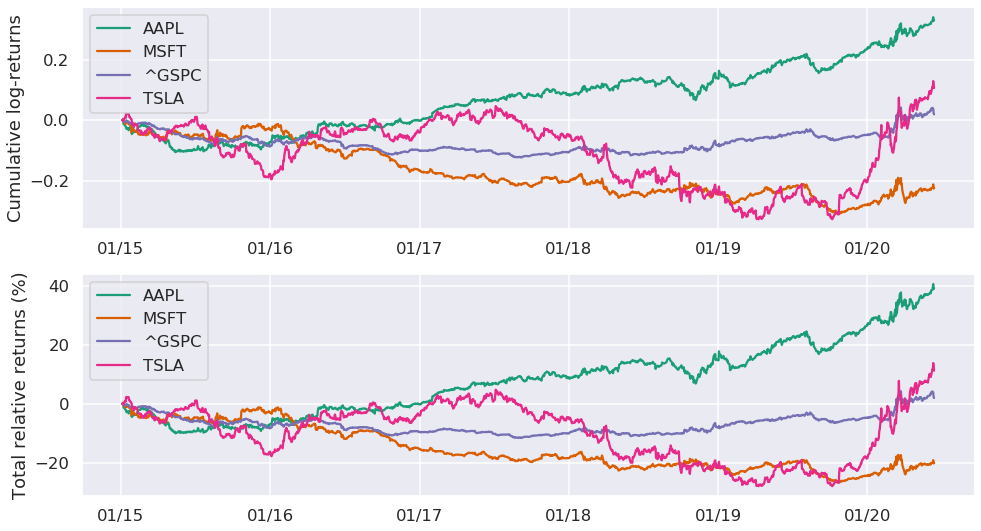

In [17]:
# Let us plot the cumulative log-returns and the cumulative total relative returns of our strategy for each of the assets.

# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns:
    ax1.plot(cum_strategy_asset_log_returns.index, cum_strategy_asset_log_returns[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

for c in asset_log_returns:
    ax2.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns[c], label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)


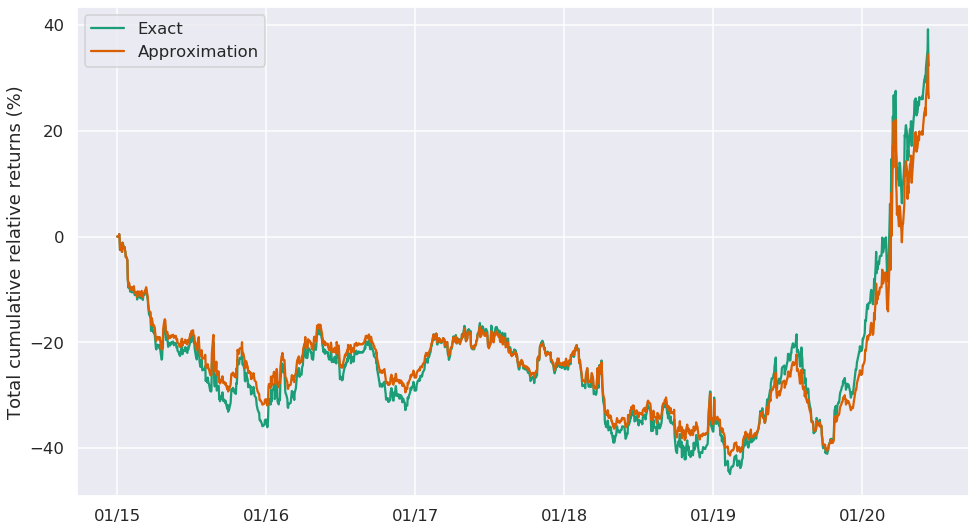

In [18]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_asset_relative_returns.sum(axis=1)

# Get the cumulative log-returns per asset
cum_strategy_log_return = cum_strategy_asset_log_returns.sum(axis=1)

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='Exact')
ax.plot(cum_relative_return_approx.index, 100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [19]:
def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 52 * 5):

    total_days_in_simulation = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = portfolio_cumulative_relative_returns[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')

print_portfolio_yearly_statistics(cum_relative_return_exact)

Total portfolio return is: 32.31%
Average yearly return is:  5.25%


Total portfolio return is: 128.19%
Average yearly return is: 16.28%


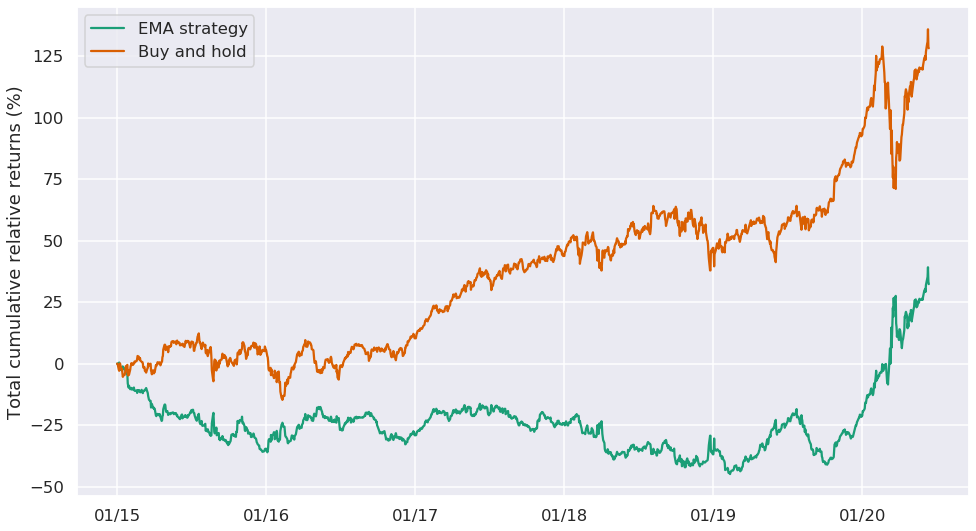

In [20]:
# Comparing the two strategies: buy and hold & moving average

# Define the weights matrix for the simple buy-and-hold strategy
simple_weights_matrix = pd.DataFrame(1/4, index = data.index, columns=data.columns)

# Get the buy-and-hold strategy log returns per asset
simple_strategy_asset_log_returns = simple_weights_matrix * asset_log_returns

# Get the cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1

# Total strategy relative returns. This is the exact calculation.
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns.sum(axis=1)

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='EMA strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

print_portfolio_yearly_statistics(simple_cum_relative_return_exact)